In [52]:
import numpy as np
import math
import pandas as pd
from statistics import mean, stdev
from tqdm.notebook import trange, tqdm
import warnings
warnings.simplefilter('ignore')

import sys
sys.path.append("../src")

from main import Agent, run
from social_force_model import SocialForceModel
from destination_choice_model import DestinationChoiceModel

In [53]:
# run this cell twice
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import matplotlib.animation as animation
%matplotlib notebook
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

In [54]:
# environment
walls = [
    np.array([(-0.5, y) for y in np.linspace(0.0, 4.0, 40)]),
    np.array([(2.5, y) for y in np.linspace(0, 1.0, 10)]),
    np.array([(2.5, y) for y in np.linspace(1.5, 2.5, 10)]),
    np.array([(2.5, y) for y in np.linspace(3.0, 4.0, 10)]),
    np.array([(x, 0) for x in np.linspace(-0.5, 2.5, 30)]),
    np.array([(x, 4.0) for x in np.linspace(-0.5, 2.5, 30)])
]
walls_points = []
for wall in walls:
    walls_points.extend(list(wall))  
walls_points = list(map(list, set(map(tuple, walls_points))))

dests = [np.array([3, 1.25]), np.array([3, 2.75])]

# for i in range(len(walls)):
#     plt.plot(walls[i][:, 0], walls[i][:, 1], c="black")

In [55]:
# parameters of SFM
params_sfm = {
    "dt": 1/30,
    "A1": 2.1,
    "B": 0.3,
    "A2": 1,
    "tau": 0.5,
    "phi": 100,
    "c": 0.5
}

# parameters of DCM
params_dcm = {
    "ASC_2": 0,
    "distance": -1.33,
    "previous_choice": 1.13,
    "others_choice_front": 0.202,
    "others_choice_behind": -0.105
}

# initial positions of agents
ped_info = pd.read_csv("../data/departure_time_and_initial_position/sample.csv")

In [56]:
# run simulation
num_step = 1500

sfm = SocialForceModel(params_sfm, walls_points)
dcm = DestinationChoiceModel(params_dcm, dests)

agents = run(ped_info, num_step, sfm, dcm, dests, real_trajectories)

<IPython.core.display.Javascript object>


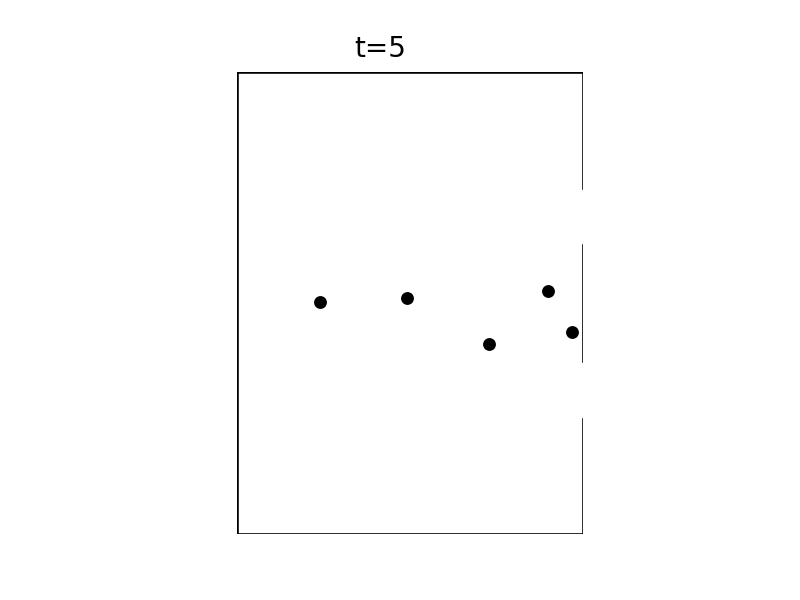

In [57]:
# visulaize as an animation
num_agent = len(agents)

ppi = 72  # points per inche

xmin, xmax = -0.5, 2.5
ymin, ymax = 0, 4

# fig = plt.figure(figsize=(6, 8), dpi=100.0)
fig = plt.figure(dpi=100.0)
ax = plt.axes()
ax.set_aspect("equal")
ax.axis("off")

ax_length = ax.bbox.get_points()[1][0]-ax.bbox.get_points()[0][0]
ax_point = ax_length*ppi/fig.dpi
xsize = xmax-xmin
fact = ax_point/xsize

plt.tick_params(labelsize=12)

#
title = ax.text(0.34, 1.05, '', transform=ax.transAxes,
                va='center', fontsize=16)
point = []
ana = []

for j in range(num_agent):
    # points, = plt.scatter([], [], s=(r[j]*2*fact)**2, color="red", linewidths=0) # color=colors[j%10])
    if agents[j].type == "real":
        points, = plt.plot([], [], 'o', c="#1f77b4",
                           markersize=agents[j].r*2*16)
    else:
        points, = plt.plot([], [], 'o', c="black",
                           markersize=agents[j].r*2*16)
#     points, = plt.plot([], [], 'o', c="black", markersize=R*2*16)
    point.append(points)

point = tuple(point)

def init():
    for j in range(num_agent):
        point[j].set_data([], [])
        title.set_text('')
    return point, title

def animate(i):
    for j in range(num_agent):

        point[j].set_data(agents[j].loc[i][0], agents[j].loc[i][1])
    title.set_text('t=' + str(int(i/30)))
    return point, title

anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=num_step, interval=30, blit=True)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

for i in range(len(walls)):
    plt.plot(walls[i][:, 0], walls[i][:, 1], c="black")

anim.save("./sample.mp4", writer="ffmpeg")